In [ ]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f97088d82e8>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
train_data['document'].nunique(), train_data['label'].nunique()
test_data['document'].nunique(), test_data['label'].nunique()

(49157, 2)

In [ ]:
train_data.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 수 :',len(train_data))
test_data.drop_duplicates(subset=['document'], inplace=True)
print('총 샘플의 수 :',len(test_data))

총 샘플의 수 : 146183
총 샘플의 수 : 49158


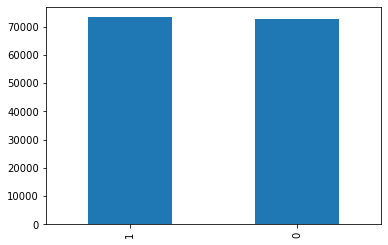

In [ ]:
train_data['label'].value_counts().plot(kind = 'bar')
test_data['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(train_data.groupby('label').size().reset_index(name = 'count')) # 정확히 몇개인지 파악하기
print(train_data.isnull().values.any()) # nan값 데이터 확인
print(train_data.isnull().sum())

print(test_data.groupby('label').size().reset_index(name = 'count')) # 정확히 몇개인지 파악하기
print(test_data.isnull().values.any()) # nan값 데이터 확인
print(test_data.isnull().sum())

   label  count
0      0  73342
1      1  72841
True
id          0
document    1
label       0
dtype: int64
   label  count
0      0  24446
1      1  24712
True
id          0
document    1
label       0
dtype: int64


In [ ]:
train_data.loc[train_data.document.isnull()] #null값을 가진 샘플이 어디에 있는지 확인

,id,document,label
25857,2172111,NaN,1


In [ ]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인
test_data = test_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(test_data.isnull().values.any()) # Null 값이 존재하는지 확인

False
False


In [ ]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


In [ ]:
test_data

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


# 불용어

In [ ]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 처리

In [ ]:
stopwords_kor = ["!","\"","$","%","&","'","(",")","*","+",",","-",".","...","0","1","2","3","4","5","6","7","8","9",";","<","=",">","?","@","\\","^","_","`","|","~","·","—","——","‘","’","“","”","…","、","。","〈","〉","《","》","가","가까스로","가령","각","각각","각자","각종","갖고말하자면","같다","같이","개의치않고","거니와","거바","거의","것","것과 같이","것들","게다가","게우다","겨우","견지에서","결과에 이르다","결국","결론을 낼 수 있다","겸사겸사","고려하면","고로","곧","공동으로","과","과연","관계가 있다","관계없이","관련이 있다","관하여","관한","관해서는","구","구체적으로","구토하다","그","그들","그때","그래","그래도","그래서","그러나","그러니","그러니까","그러면","그러므로","그러한즉","그런 까닭에","그런데","그런즉","그럼","그럼에도 불구하고","그렇게 함으로써","그렇지","그렇지 않다면","그렇지 않으면","그렇지만","그렇지않으면","그리고","그리하여","그만이다","그에 따르는","그위에","그저","그중에서","그치지 않다","근거로","근거하여","기대여","기점으로","기준으로","기타","까닭으로","까악","까지","까지 미치다","까지도","꽈당","끙끙","끼익","나","나머지는","남들","남짓","너","너희","너희들","네","넷","년","논하지 않다","놀라다","누가 알겠는가","누구","다른","다른 방면으로","다만","다섯","다소","다수","다시 말하자면","다시말하면","다음","다음에","다음으로","단지","답다","당신","당장","대로 하다","대하면","대하여","대해 말하자면","대해서","댕그","더구나","더군다나","더라도","더불어","더욱더","더욱이는","도달하다","도착하다","동시에","동안","된바에야","된이상","두번째로","둘","둥둥","뒤따라","뒤이어","든간에","들","등","등등","딩동","따라","따라서","따위","따지지 않다","딱","때","때가 되어","때문에","또","또한","뚝뚝","라 해도","령","로","로 인하여","로부터","로써","륙","를","마음대로","마저","마저도","마치","막론하고","만 못하다","만약","만약에","만은 아니다","만이 아니다","만일","만큼","말하자면","말할것도 없고","매","매번","메쓰겁다","몇","모","모두","무렵","무릎쓰고","무슨","무엇","무엇때문에","물론","및","바꾸어말하면","바꾸어말하자면","바꾸어서 말하면","바꾸어서 한다면","바꿔 말하면","바로","바와같이","밖에 안된다","반대로","반대로 말하자면","반드시","버금","보는데서","보다더","보드득","본대로","봐","봐라","부류의 사람들","부터","불구하고","불문하고","붕붕","비걱거리다","비교적","비길수 없다","비로소","비록","비슷하다","비추어 보아","비하면","뿐만 아니라","뿐만아니라","뿐이다","삐걱","삐걱거리다","사","삼","상대적으로 말하자면","생각한대로","설령","설마","설사","셋","소생","소인","솨","쉿","습니까","습니다","시각","시간","시작하여","시초에","시키다","실로","심지어","아","아니","아니나다를가","아니라면","아니면","아니었다면","아래윗","아무거나","아무도","아야","아울러","아이","아이고","아이구","아이야","아이쿠","아하","아홉","안 그러면","않기 위하여","않기 위해서","알 수 있다","알았어","앗","앞에서","앞의것","야","약간","양자","어","어기여차","어느","어느 년도","어느것","어느곳","어느때","어느쪽","어느해","어디","어때","어떠한","어떤","어떤것","어떤것들","어떻게","어떻해","어이","어째서","어쨋든","어쩔수 없다","어찌","어찌됏든","어찌됏어","어찌하든지","어찌하여","언제","언젠가","얼마","얼마 안 되는 것","얼마간","얼마나","얼마든지","얼마만큼","얼마큼","엉엉","에","에 가서","에 달려 있다","에 대해","에 있다","에 한하다","에게","에서","여","여기","여덟","여러분","여보시오","여부","여섯","여전히","여차","연관되다","연이서","영","영차","옆사람","예","예를 들면","예를 들자면","예컨대","예하면","오","오로지","오르다","오자마자","오직","오호","오히려","와","와 같은 사람들","와르르","와아","왜","왜냐하면","외에도","요만큼","요만한 것","요만한걸","요컨대","우르르","우리","우리들","우선","우에 종합한것과같이","운운","월","위에서 서술한바와같이","위하여","위해서","윙윙","육","으로","으로 인하여","으로서","으로써","을","응","응당","의","의거하여","의지하여","의해","의해되다","의해서","이","이 되다","이 때문에","이 밖에","이 외에","이 정도의","이것","이곳","이때","이라면","이래","이러이러하다","이러한","이런","이럴정도로","이렇게 많은 것","이렇게되면","이렇게말하자면","이렇구나","이로 인하여","이르기까지","이리하여","이만큼","이번","이봐","이상","이어서","이었다","이와 같다","이와 같은","이와 반대로","이와같다면","이외에도","이용하여","이유만으로","이젠","이지만","이쪽","이천구","이천육","이천칠","이천팔","인 듯하다","인젠","일","일것이다","일곱","일단","일때","일반적으로","일지라도","임에 틀림없다","입각하여","입장에서","잇따라","있다","자","자기","자기집","자마자","자신","잠깐","잠시","저","저것","저것만큼","저기","저쪽","저희","전부","전자","전후","점에서 보아","정도에 이르다","제","제각기","제외하고","조금","조차","조차도","졸졸","좀","좋아","좍좍","주룩주룩","주저하지 않고","줄은 몰랏다","줄은모른다","중에서","중의하나","즈음하여","즉","즉시","지든지","지만","지말고","진짜로","쪽으로","차라리","참","참나","첫번째로","쳇","총적으로","총적으로 말하면","총적으로 보면","칠","콸콸","쾅쾅","쿵","타다","타인","탕탕","토하다","통하여","툭","퉤","틈타","팍","팔","퍽","펄렁","하","하게될것이다","하게하다","하겠는가","하고 있다","하고있었다","하곤하였다","하구나","하기 때문에","하기 위하여","하기는한데","하기만 하면","하기보다는","하기에","하나","하느니","하는 김에","하는 편이 낫다","하는것도","하는것만 못하다","하는것이 낫다","하는바","하더라도","하도다","하도록시키다","하도록하다","하든지","하려고하다","하마터면","하면 할수록","하면된다","하면서","하물며","하여금","하여야","하자마자","하지 않는다면","하지 않도록","하지마","하지마라","하지만","하하","한 까닭에","한 이유는","한 후","한다면","한다면 몰라도","한데","한마디","한적이있다","한켠으로는","한항목","할 따름이다","할 생각이다","할 줄 안다","할 지경이다","할 힘이 있다","할때","할만하다","할망정","할뿐","할수있다","할수있어","할줄알다","할지라도","할지언정","함께","해도된다","해도좋다","해봐요","해서는 안된다","해야한다","해요","했어요","향하다","향하여","향해서","허","허걱","허허","헉","헉헉","헐떡헐떡","형식으로 쓰여","혹시","혹은","혼자","훨씬","휘익","휴","흐흐","흥","힘입어","︿","！","＃","＄","％","＆","（","）","＊","＋","，","０","１","２","３","４","５","６","７","８","９","：","；","＜","＞","？","＠","［","］","｛","｜","｝","～","￥"]


##okt

In [ ]:
okt = Okt()

## 토큰화 과정

In [ ]:
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [ ]:
len(X_train)

146182

In [ ]:
X_train_all = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords_kor] # 불용어 제거
    X_train_all.append(temp_X)

In [ ]:
X_train_all

[['더빙', '..', '진짜', '짜증나다', '목소리'],
 ['흠', '포스터', '보고', '초딩', '영화', '줄', '....', '오버', '연기', '가볍다', '않다'],
 ['무재', '밓었', '다그', '래서', '보다', '추천', '한', '다'],
 ['교도소', '이야기', '구먼', '..', '솔직하다', '재미', '는', '없다', '..', '평점', '조정'],
 ['사이',
  '몬페',
  '익살스럽다',
  '연기',
  '돋보이다',
  '영화',
  '스파이더맨',
  '늙다',
  '보이다',
  '하다',
  '커스틴',
  '던스트',
  '너무나도',
  '이쁘다',
  '보이다'],
 ['막',
  '걸음',
  '마',
  '떼다',
  '세',
  '초등학교',
  '학년',
  '생인',
  '살다',
  '영화',
  'ㅋㅋㅋ',
  '별',
  '반개',
  '도',
  '아깝다',
  '움'],
 ['원작', '긴장감', '제대로', '살리다', '하다'],
 ['별',
  '반개',
  '도',
  '아깝다',
  '욕',
  '나오다',
  '이응경',
  '길용우',
  '연',
  '기',
  '생활',
  '인지',
  '..',
  '정말',
  '발',
  '해도',
  '그것',
  '보단',
  '낫다',
  '납치',
  '감금',
  '만',
  '반복',
  '반복',
  '..',
  '드라마',
  '는',
  '가족',
  '도',
  '없다',
  '연기',
  '못',
  '하다',
  '사람',
  '만',
  '엿'],
 ['액션', '없다', '재미', '안되다', '영화'],
 ['왜케',
  '평점',
  '낮다',
  '꽤',
  '볼',
  '만',
  '한',
  '데',
  '..',
  '헐리우드',
  '식',
  '화려하다',
  '너무',
  '길들이다'],
 ['걍', '인피니트', '짱', '이다', '진짜', '짱', '이다', '

In [ ]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_test.append(temp_X)

In [ ]:
X_test_all = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords_kor] # 불용어 제거
    X_test_all.append(temp_X)

## ','를 ' '정리

In [ ]:
k_t_all = []
for i in range(len(X_train_all)):
    k_t_all.append((' ').join(X_train_all[i]))
k_t_all

['더빙 .. 진짜 짜증나다 목소리',
 '흠 포스터 보고 초딩 영화 줄 .... 오버 연기 가볍다 않다',
 '무재 밓었 다그 래서 보다 추천 한 다',
 '교도소 이야기 구먼 .. 솔직하다 재미 는 없다 .. 평점 조정',
 '사이 몬페 익살스럽다 연기 돋보이다 영화 스파이더맨 늙다 보이다 하다 커스틴 던스트 너무나도 이쁘다 보이다',
 '막 걸음 마 떼다 세 초등학교 학년 생인 살다 영화 ㅋㅋㅋ 별 반개 도 아깝다 움',
 '원작 긴장감 제대로 살리다 하다',
 '별 반개 도 아깝다 욕 나오다 이응경 길용우 연 기 생활 인지 .. 정말 발 해도 그것 보단 낫다 납치 감금 만 반복 반복 .. 드라마 는 가족 도 없다 연기 못 하다 사람 만 엿',
 '액션 없다 재미 안되다 영화',
 '왜케 평점 낮다 꽤 볼 만 한 데 .. 헐리우드 식 화려하다 너무 길들이다',
 '걍 인피니트 짱 이다 진짜 짱 이다 ♥',
 '볼때 마다 눈물나다 죽다 90년 대의 향수 자극 !! 허진호 는 감성 절제 멜로 달인 이다',
 '울면 서 손 고 횡단보도 건너다 뛰다 치다 올 뻔 이범수 연기 드럽다 못 하다',
 '담백하다 깔끔하다 좋다 신 문 기 로만 보다 보다 자꾸 잊어버리다 도 사람 이다',
 '취향 은 존중 한 다지 만 진짜 내생 극장 보다 영화 중 가장 노잼 노 감동 임 스토리 도 어거지 고 감동 도 어거지',
 'ㄱ 냥 긴장 되다 재밋음 ㅠㅠ',
 '차다 사람 웃기다 바스코 이기 면 락스 코 라고 끄다 바비 이기 면 아이돌 이라고 깔다 그냥 끄다 안달 난 처럼 보이다',
 '굿바이 레닌 표절 인 은 이해 하다 뒤 갈수록 재미 없어지다',
 '이건 정말 깨알 캐스팅 질퍽 지 않다 산뜻하다 내 용구성 자다 버무러진 깨알 일드 !! ♥',
 '약탈 위 한 변명 이르다 놈 은 착하다 놈 절대 아니다 걸 요',
 '나름 심오하다 뜻 도 듯 그냥 학생 선생 놀다 영화 는 절대 아니다',
 '보다 웃다 않다 건 불가능하다',
 '재미없다 지루하다 음식 영화 인데 도 바베트 만찬 하

In [ ]:
k_t_some = []
for i in range(len(X_train)):
    k_t_some.append((' ').join(X_train[i]))
k_t_some

['아 더빙 .. 진짜 짜증나다 목소리',
 '흠 ... 포스터 보고 초딩 영화 줄 .... 오버 연기 조차 가볍다 않다',
 '너 무재 밓었 다그 래서 보다 추천 다',
 '교도소 이야기 구먼 .. 솔직하다 재미 없다 .. 평점 조정',
 '사이 몬페 그 익살스럽다 연기 돋보이다 영화 ! 스파이더맨 에서 늙다 보이다 커스틴 던스트 너무나도 이쁘다 보이다',
 '막 걸음 마 떼다 3 세 부터 초등학교 1 학년 생인 8 살다 영화 . ㅋㅋㅋ ... 별 반개 아깝다 움 .',
 '원작 긴장감 을 제대로 살리다 .',
 '별 반개 아깝다 욕 나오다 이응경 길용우 연 기 생활 몇 년 인지 .. 정말 발 로 해도 그것 보단 낫다 납치 . 감금 만 반복 반복 .. 드라마 가족 없다 연기 못 사람 만 모 엿 네',
 '액션 없다 재미 있다 몇 안되다 영화',
 '왜케 평점 낮다 ? 꽤 볼 만 데 .. 헐리우드 식 화려하다 너무 길들이다 있다 ?',
 '인피니트 짱 이다 . 진짜 짱 이다 ♥',
 '볼때 마다 눈물나다 죽다 90년 대의 향수 자극 !! 허진호 감성 절제 멜로 달인 이다 ~',
 '울면 서 손 고 횡단보도 건너다 때 뛰다 치다 올 뻔 이범수 연기 드럽다 못',
 '담백하다 깔끔하다 좋다 . 신 문 기 사 로만 보다 보다 자꾸 잊어버리다 . 그 사람 이다 것 을 .',
 '취향 존중 다지 만 진짜 내생 극장 에서 보다 영화 중 가장 노잼 노 감동 임 스토리 어거지 고 감동 어거지',
 'ㄱ 냥 매번 긴장 되다 재밋음 ㅠㅠ',
 '차다 사람 웃기다 바스코 이기 면 락스 코 라고 끄다 바비 이기 면 아이돌 이라고 깔다 . 그냥 끄다 안달 난 것 처럼 보이다',
 '굿바이 레닌 표절 인 것 이해 왜 뒤 로 갈수록 재미 없어지다',
 '이건 정말 깨알 캐스팅 질퍽 하 지 않다 산뜻하다 내 용구성 자다 버무러진 깨알 일드 !! ♥',
 '약탈 위 변명 , 이르다 . 저 놈 착하다 놈 절대 아니다 걸 요 .',
 '나름 심오하다 뜻 있다 듯 . 그냥 학생 선생 놀다 영화 

In [ ]:
k_te_some = []
for i in range(len(X_test)):
    k_te_some.append((' ').join(X_test[i]))
k_te_some

['굳다 ㅋ',
 'GDNTOPCLASSINTHECLUB',
 '뭐 야 평점 .... 나쁘다 않다 10 점 짜다 리 더 더욱 아니다',
 '지루하다 않다 완전 막장 임 ... 돈 주다 보기 에는 ....',
 '3 D 만 아니다 별 다섯 개 주다 .. 왜 3 D 로 나오다 제 심기 불편하다 ??',
 '음악 주가 되다 , 최고 음악 영화',
 '진정하다 쓰레기',
 '마치 미국 애니 에서 튀어나오다 창의력 없다 로봇 디자인 부터가 , 고개 젖다',
 '갈수록 개판 되다 중국영화 유치하다 내용 없다 폼 잡다 끝나다 말 안되다 무기 유치하다 cg 남무 아 그리다 동사서독 같다 영화 이건 3 류 아 류작 이다',
 '이별 아픔 뒤 찾아오다 새롭다 인연 기쁨 But , 모든 사람 그렇다 않다 ..',
 '괜찮다 오랜 만 포켓몬스터 잼밌 어 요',
 '한국 독립영화 한계 그렇게 아버지 되다 비교 되다',
 '청춘 아름답다 그 아름답다 움 이성 을 흔들다 놓다 . 찰나 아름답다 움 을 자다 포착 섬세하다 아름답다 수채화 같다 퀴어 영화 이다 .',
 '눈 보이다 반전 이다 영화 흡인 력 사라지다 않다 .',
 '" 스토리 , 연출 , 연기 , 비주 얼 등 영화 기본 조차 안되다 영화 무슨 평 을 해 . 이렇다 영화 찍다 김문옥 감독 "" 내 영화 경력 몇 OO 인데 조무래기 내 영화 평론 ?"" 같다 마인드 빠지다 ?"',
 '소위 ㅈ 문 가라 평점 뭐 냐 ?',
 '최고 !!!!!!!!!!!!!!!!',
 '발연기 도저히 못 보다 진짜 이렇게 연기 못 상상 못',
 '나이스',
 '별 재미 없다 우려 먹다 .... 챔프 에서 방송 몇번 ? ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 "' 13일 금요일 ', ' 나이트메어 ' 시리즈 함께 가장 많다 시리즈 양산 해내다 헬레 저 시리즈 첫 편 . 작가 상상력 돋보이다 작품 이며 , 갈고리 로 사지 찢다 고어씬 지금 보더 라도 상당하다 잔인하다 충격 적 이다 .",
 '나름 교훈 돋다 하지만 어쩔 수없이 저 평점 받다 없다 저 질 섹스 코미

In [ ]:
k_te_all = []
for i in range(len(X_test_all)):
    k_te_all.append((' ').join(X_test_all[i]))
k_te_all

['굳다 ㅋ',
 'GDNTOPCLASSINTHECLUB',
 '뭐 평점 은 .... 나쁘다 않다 10 점 짜다 리 는 더 더욱 아니다',
 '지루하다 않다 완전 막장 임 돈 주다 보기 에는 ....',
 'D 만 아니다 별 개 주다 .. D 나오다 심기 불편하다 하다 ??',
 '음악 주가 되다 최고 음악 영화',
 '진정하다 쓰레기',
 '미국 애니 튀어나오다 한 창의력 없다 로봇 디자인 부터가 고개 젖다 하다',
 '갈수록 개판 되다 중국영화 유치하다 내용 없다 폼 잡다 끝나다 말 도 안되다 무기 유치하다 cg 남무 그리다 동사서독 영화 이건 류 류작 이다',
 '이별 아픔 뒤 찾아오다 새롭다 인연 기쁨 But 모든 사람 그렇다 않다 ..',
 '괜찮다 오랜 만 포켓몬스터 잼밌 요',
 '한국 독립영화 한계 그렇게 아버지 되다 비교 되다',
 '청춘 은 아름답다 아름답다 움 은 이성 흔들다 놓다 찰나 아름답다 움 자다 포착 한 섬세하다 아름답다 수채화 퀴어 영화 이다',
 '눈 보이다 반전 이다 영화 흡인 력 은 사라지다 않다',
 '스토리 연출 연기 비주 얼 영화 기본 안되다 영화 평 해 이렇다 영화 찍다 김문옥 감독 은 "" 내 영화 경력 OO 인데 조무래기 내 영화 평론 하다 ?"" 마인드 빠지다 ?"',
 '소위 ㅈ 문 가라 는 평점 은 뭐 냐',
 '최고 !!!!!!!!!!!!!!!!',
 '발연기 도저히 못 보다 진짜 이렇게 연기 못 하다 상상 도 못 하다',
 '나이스',
 '별 재미 도 없다 우려 먹다 .... 챔프 방송 몇번 하다 ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ',
 "13일 금요일 ', 나이트메어 시리즈 가장 많다 시리즈 양산 해내다 헬레 시리즈 첫 편 작가 상상력 돋보이다 작품 이며 갈고리 사지 찢다 고어씬 은 지금 보더 라도 상당하다 잔인하다 충격 적 이다",
 '나름 교훈 돋다 어쩔 수없이 평점 받다 없다 질 섹스 코미디',
 '꽤 재밌다 보다 영화 이다',
 '민주화 시대 억눌리다 영혼 관음 적 인 욕구 분출 인상 적 이다',
 '일본 천황

In [ ]:
train_data

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


## Data Frame 정리

In [ ]:
train_data['train_words_some'] = k_t_some

In [ ]:
train_data

,id,document,label,train_words_some
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,아 더빙 .. 진짜 짜증나다 목소리
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,흠 ... 포스터 보고 초딩 영화 줄 .... 오버 연기 조차 가볍다 않다
2,10265843,너무재밓었다그래서보는것을추천한다,0,너 무재 밓었 다그 래서 보다 추천 다
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,교도소 이야기 구먼 .. 솔직하다 재미 없다 .. 평점 조정
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이 몬페 그 익살스럽다 연기 돋보이다 영화 ! 스파이더맨 에서 늙다 보이다 커스틴...
...,...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0,인간 문제 지 .. 소 뭔 죄인 ..
149996,8549745,평점이 너무 낮아서...,1,평점 너무 낮다 ...
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0,게 뭐 요 ? 한국인 거들다 먹거리 고 필리핀 혼혈 착하다 ?
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1,청춘 영화 최고봉 . 방황 우울하다 날 자화상


In [ ]:
train_data['train_words_all'] =  k_t_all

In [ ]:
train_data

,id,document,label,train_words_some,train_words_all
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0,아 더빙 .. 진짜 짜증나다 목소리,더빙 .. 진짜 짜증나다 목소리
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1,흠 ... 포스터 보고 초딩 영화 줄 .... 오버 연기 조차 가볍다 않다,흠 포스터 보고 초딩 영화 줄 .... 오버 연기 가볍다 않다
2,10265843,너무재밓었다그래서보는것을추천한다,0,너 무재 밓었 다그 래서 보다 추천 다,무재 밓었 다그 래서 보다 추천 한 다
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0,교도소 이야기 구먼 .. 솔직하다 재미 없다 .. 평점 조정,교도소 이야기 구먼 .. 솔직하다 재미 는 없다 .. 평점 조정
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1,사이 몬페 그 익살스럽다 연기 돋보이다 영화 ! 스파이더맨 에서 늙다 보이다 커스틴...,사이 몬페 익살스럽다 연기 돋보이다 영화 스파이더맨 늙다 보이다 하다 커스틴 던스트...
...,...,...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0,인간 문제 지 .. 소 뭔 죄인 ..,인간 문제 지 .. 소 는 뭔 죄인 ..
149996,8549745,평점이 너무 낮아서...,1,평점 너무 낮다 ...,평점 너무 낮다
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0,게 뭐 요 ? 한국인 거들다 먹거리 고 필리핀 혼혈 착하다 ?,게 뭐 요 한국인 은 거들다 먹거리 고 필리핀 혼혈 은 착하다
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1,청춘 영화 최고봉 . 방황 우울하다 날 자화상,청춘 영화 최고봉 방황 우울하다 날 자화상


In [ ]:
test_data['test_words_some'] = k_te_some

In [ ]:
test_data['test_words_all'] = k_te_all

In [ ]:
test_data

,id,document,label,test_words_some,test_words_all
0,6270596,굳 ㅋ,1,굳다 ㅋ,굳다 ㅋ
1,9274899,GDNTOPCLASSINTHECLUB,0,GDNTOPCLASSINTHECLUB,GDNTOPCLASSINTHECLUB
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0,뭐 야 평점 .... 나쁘다 않다 10 점 짜다 리 더 더욱 아니다,뭐 평점 은 .... 나쁘다 않다 10 점 짜다 리 는 더 더욱 아니다
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0,지루하다 않다 완전 막장 임 ... 돈 주다 보기 에는 ....,지루하다 않다 완전 막장 임 돈 주다 보기 에는 ....
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0,3 D 만 아니다 별 다섯 개 주다 .. 왜 3 D 로 나오다 제 심기 불편하다 ??,D 만 아니다 별 개 주다 .. D 나오다 심기 불편하다 하다 ??
...,...,...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1,오랜 만 평점 로 기다 ㅋㅋ 킹왕짱 쌈뽕 영화 만나다 강렬하다 육 쾌함,오랜 만 평점 기다 하다 ㅋㅋ 킹왕짱 쌈뽕 한 영화 만나다 강렬하다 쾌함
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0,의지 박약 이나 탈영 일단 주인공 김대희 닮다 이등병 찌다 따다 OOOO,의지 박약 이나 하다 탈영 은 주인공 김대희 닮다 이등병 찌다 따다 OOOO
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0,그림 좋다 완성 도도 높다 ... 보다 내내 불안하다 만들다,그림 도 좋다 완성 도도 높다 보다 내내 불안하다 만들다
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0,절대 보다 서다 안 되다 영화 .. 재미 없다 기분 만 잡 치고 .. 세트 장 에서...,절대 보다 서다 안 되다 영화 .. 재미 도 없다 기분 만 잡 치고 .. 하다 세트...


## pickle

In [ ]:
import pickle
with open('news_train_data.pickle','wb') as f: #저장
    pickle.dump(train_data , f)

import pickle
with open('news_test_data.pickle','wb') as f: #저장
    pickle.dump(test_data , f)


#1번 CNN static


In [1]:
!pip install tensorflow
import tensorflow as tf
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
# from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

import pickle


In [2]:
import pickle

with open(r'C:\Users\student\mulcamp_b\news_train_data.pickle', 'rb') as f: #불러오기
    train = pickle.load(f)

FileNotFoundError: ignored

In [ ]:
import pickle

with open(r'C:\Users\student\mulcamp_b\news_test_data.pickle', 'rb') as f: #불러오기
    test = pickle.load(f)

In [3]:
X_train = train['train_words_all']
y_train = train['label'] 
X_test = test['test_words_all']
y_test = test['label']

NameError: ignored

In [3]:
oov_tok = '<OOV>'
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index)

print(vocab_size)

In [3]:
X_encoded = tokenizer.texts_to_sequences(X_train)
# print(X_encoded)
max_length=max(len(l) for l in X_encoded)
print(max_length)

In [3]:
truct_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

max_length=max_length
vocab_size=vocab_size
embedding_dim = 300

In [3]:
tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

X_train  = tokenizer.texts_to_sequences(X_train)
X_train_padded= pad_sequences(X_train, maxlen=max_length, 
                                padding=padding_type, truncating=truct_type)


X_test = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test, maxlen=max_length, 
                                padding=padding_type, truncating=truct_type)

In [3]:
X_train_padded = np.array(X_train_padded)
y_train = np.array(y_train)

X_test_padded = np.array(X_test_padded)
y_test = np.array(y_test)

In [3]:
X_train_padded.shape, y_train.shape, X_test_padded.shape, y_test.shape

In [3]:
with open('dh_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
import json
from collections import OrderedDict
parameter = OrderedDict()
parameter['vocab_size'] = vocab_size
parameter['embedding_dim'] = 300
parameter['max_len'] = max_length
parameter['pad_type'] = 'pre'
parameter['trunc_type'] = 'post'
print(json.dumps(parameter,ensure_ascii=False, indent='\t'))
with open('dh_params.json', 'w', encoding='utf-8') as make_file:
  json.dump(parameter, make_file, ensure_ascii=False, indent='\t')



In [3]:
import subprocess

with open(r"C:\Users\student\mulcamp_b\wiki.ko.vec", encoding='utf-8') as f:
    wiki = f.readlines()

In [3]:
embedding_dict = dict()

for line in wiki:
    word_vector = line.split()
    word = word_vector[0]
    word_vector_arr = np.asarray(word_vector[1:], dtype='float32') 
    embedding_dict[word] = word_vector_arr
# f.close()
print('%s개의 Embedding vector가 있습니다.' % len(embedding_dict))

In [3]:
embedding_matrix = np.zeros((vocab_size+1 , embedding_dim))
# 단어 집합 크기의 행과 100개의 열을 가지는 행렬 생성. 값은 전부 0으로 채워진다.
np.shape(embedding_matrix)

In [3]:
out_index = 0
for word, i in word_index.items(): # 훈련 데이터의 단어 집합에서 단어를 1개씩 꺼내온다.
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        out_index += 1

print(out_index)

In [3]:
embedding_matrix.shape

In [3]:
embedding_matrix[2]

In [3]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate


sequence_input = Input(shape=(max_length,), dtype='int32')

embedding_layer = Embedding(vocab_size+1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

embedded_sequences = embedding_layer(sequence_input)

In [3]:
from tensorflow.keras import regularizers

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = Conv1D(128, fsz, activation='relu',padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.003))(embedded_sequences)
    x = MaxPooling1D()(x)
    convs.append(x)
    
x = Concatenate(axis=-1)(convs)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(sequence_input, output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

In [3]:
num_epochs = 30
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0.002, verbose=0, mode='auto', baseline=None, restore_best_weights=True)

history = model.fit(X_train_padded, y_train,
#                     class_weight = class_weights_d,
                    epochs=num_epochs,
                    verbose=True,
                    validation_data=(X_test_padded, y_test),
                    batch_size=50,
                   callbacks=[callback])
loss, accuracy = model.evaluate(X_train_padded, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
# plot_history(history)

In [3]:
sentence = ["완전 재미있다 엉엉", "그저그런 영화"]
sequence_exp = tokenizer.texts_to_sequences(sentence)
padded_exp = pad_sequences(sequence_exp, maxlen = max_length, padding = 'post', truncating= 'post')
print(model.predict(padded_exp).round(2))

In [3]:
!mkdir -p saved_model
model.save('saved_model/my_model')
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model.summary()

In [3]:
sentence = ["완전 재미있다 엉엉", "그저그런 영화"]
sequence_exp = tokenizer.texts_to_sequences(sentence)
padded_exp = pad_sequences(sequence_exp, maxlen = max_length, padding = 'post', truncating= 'post')
print(new_model.predict(padded_exp).round(2))

#2번 CNN-non-static


In [3]:
!pip install gensim

In [3]:
#명령어
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

In [3]:
vocab_size = 47228
embedding_dim = 300
max_length = 71
truct_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [3]:
import pickle
with open('news_train_data.pickle', 'rb') as f: #불러오기
      train_data = pickle.load(f)
        
with open('news_test_data.pickle', 'rb') as f: #불러오기
      test_data = pickle.load(f)

In [3]:
data = train_data['train_words_all']

In [3]:
from gensim.models import FastText

Fast_naver = FastText(data, 
                 size=300, 
                 window=5, 
                 min_count=10, 
                 alpha=0.025, 
                 sg=1, 
                 iter=200
                   )

In [3]:
Fast_naver

In [3]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(data)
word_index = tokenizer.word_index

In [3]:
Fasttext_naver = list(word_index.keys())
Fasttext_naver[-1]

In [3]:
Fasttext_naver_1= Fast_naver.wv.__getitem__(Fasttext_naver)
Fasttext_naver_1.shape

In [4]:
training_sequences  = tokenizer.texts_to_sequences(data)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=truct_type)

testing_sequences  = tokenizer.texts_to_sequences(test_data['test_words_all'])
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=truct_type)

NameError: ignored

In [4]:
training_padded = np.array(training_padded)
training_labels = np.array(train_data['label'])

testing_padded = np.array(testing_padded)
testing_labels = np.array(test_data['label'])

In [4]:
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate
sequence_input = Input(shape=(max_length,), dtype='int32')
embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights=[Fasttext_naver_1],
                            input_length=max_length,
                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)

In [4]:
from tensorflow.keras import regularizers
convs = []
filter_sizes = [3,4,5]
for fsz in filter_sizes:
    x = Conv1D(128, fsz, activation='relu',padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.003))(embedded_sequences)
    x = MaxPooling1D()(x)
    convs.append(x)
x = Concatenate(axis=-1)(convs)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)
model = tf.keras.Model(sequence_input, output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

In [4]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [4]:
!mkdir -p saved_model
model.save('saved_model/my_model') # 학습된 모델 저장

In [4]:
new_model = tf.keras.models.load_model('saved_model/my_model')
new_model

In [4]:
sentence = ["완전 재미있다 엉엉", "그저그런 영화"]
sequence_exp = tokenizer.texts_to_sequences(sentence)
padded_exp = pad_sequences(sequence_exp, maxlen = max_length, padding = 'post', truncating= 'post')
print(new_model.predict(padded_exp).round(2))

#3번 Sent2Vec



In [4]:
with open('news_train_data.pickle', 'rb') as f: #불러오기
    train_data = pickle.load(f)

In [4]:
with open('news_test_data.pickle', 'rb') as f: #불러오기
    test_data = pickle.load(f)

In [4]:
k = train_data['train_words_all']
train_words_all = list(k)
type(train_words_all)

In [4]:
k = test_data['test_words_all']
test_words_all = list(k)
type(test_words_all)

In [4]:
#명령어
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate
from keras.models import load_model
from keras import regularizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.text import Tokenizer 
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Input, layers
from keras.models import load_model

In [4]:
#파라미터
vocab_size = 30000
embedding_dim = 50
max_length = 70
truct_type = 'pre'
padding_type = 'pre'
oov_tok = '<OOV>'

In [4]:
import json
from collections import OrderedDict
parameter = OrderedDict()

parameter['vocab_size'] = 30000
parameter['embedding_dim'] = 50
parameter['max_length'] = 70
parameter['padding_type'] = 'pre'
parameter['truct_type'] = 'pre'

print(json.dumps(parameter,ensure_ascii=False, indent='\t'))
with open('parameter.json', 'w', encoding='utf-8') as make_file:
  json.dump(parameter, make_file, ensure_ascii=False, indent='\t')

In [4]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_words_all)
word_index = tokenizer.word_index

training_sequences  = tokenizer.texts_to_sequences(train_words_all)
training_padded = pad_sequences(training_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=truct_type)

testing_sequences  = tokenizer.texts_to_sequences(test_words_all)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, 
                                padding=padding_type, truncating=truct_type)

In [4]:
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [4]:
training_padded = np.array(training_padded)
training_labels = np.array(train_data['label'])

testing_padded = np.array(testing_padded)
testing_labels = np.array(test_data['label'])

In [4]:
sequence_input = tf.keras.Input(shape=(max_length,), dtype='int32')
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            embedding_dim,
                                            input_length=max_length,
                                            trainable=False)
embedded_sequences = embedding_layer(sequence_input)
convs = []
filter_sizes = [3,4,5]
for fsz in filter_sizes:

    x = tf.keras.layers.Conv1D(100, fsz, activation='relu',padding='same')(embedded_sequences)
    x = tf.keras.layers.MaxPooling1D()(x)
    convs.append(x)

x = tf.keras.layers.Concatenate(axis=-1)(convs)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)

x = tf.keras.layers.Dropout(0.5)(x)

output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(sequence_input, output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

In [4]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [4]:
num_epochs = 20
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2, callbacks=[callback])


In [4]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [5]:
!mkdir -p saved_model
model.save('saved_model_naver/my_model')

NameError: ignored

In [6]:
sentence = ["완전 재미있다 엉엉", "그저그런 영화"]
sequence_exp = tokenizer.texts_to_sequences(sentence)
padded_exp = pad_sequences(sequence_exp, maxlen = max_length, padding = 'pre', truncating= 'pre')
print(model.predict(padded_exp).round(2))

NameError: ignored

In [ ]:
sentence = ["완전 재미있다 엉엉", "그저그런 영화"]
sequence_exp = tokenizer.texts_to_sequences(sentence)
padded_exp = pad_sequences(sequence_exp, maxlen = max_length, padding = 'post', truncating= 'post')
print(model.predict(padded_exp).round(2))